# Tutorial (Image Data Processing)

(Last updated: Mar 5, 2024)[^credit]

[^credit]: Credit: this teaching material is created by Bryan Fleming and revised by [Alejandro Monroy](https://github.com/amonroym99) under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

Here is an online version of [this notebook in Google Colab](https://colab.research.google.com/drive/17eDq0aIYNRipcjpZ6SApMUtcCPpyOvlQ?usp=sharing). This online version is just for browsing. To work on this notebook, you need to copy a new one to your own Google Colab.

This tutorial will guide you through the entire pipeline for training an image classifier using PyTorch and deep neural networks.

In [ ]:
!pip install torchviz

In [ ]:
!pip install torch

In [ ]:
!pip install pydot

In [ ]:
!pip install pydotplus

In [ ]:
!pip install grad-cam

In [ ]:
# Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.autograd import Variable
from torchviz import make_dot
from IPython.display import Image
import base64
import matplotlib.pyplot as plt
import warnings
from IPython.display import HTML
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

**First, you need to enable GPUs for the notebook in Google Colab:**

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # use CUDA device
elif torch.backends.mps.is_available:
    device = torch.device("mps")          # use MPS device
else:
    device = torch.device("cpu")           # use CPU device
device

device(type='cuda')

Make sure that the ouput from the above cell is `device(type='cuda')`. If you see `device(type='cpu')`, it means that you did not enable GPU usage on Google Colab. Go to [this page](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html) and check the "Use GPU as an accelerator" part for details. Please be patient for this tutorial and the assignment, as training neural networks for Computer Vision tasks typically takes a lot of time.

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Scenario

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/docs/images/tablet.jpg?raw=true)

Image source -- https://www.istockphoto.com/nl/foto/ancient-text-gm139879372-1545295

As an aspiring machine learning enthusiast, you have been presented with a challenge. A team of archeologists has discovered an ancient text written on a mysterious tablet that nobody has ever seen before. The script on this is so complex that no one has been able to decipher it, even after months of studying it.

However, you have a hunch that machine learning could be used to decipher the tablet's script. You have been tasked with converting the ancient script into a string of modern numbers, as it is suspected to be some kind of Mathematical Algorithm. You need to turn the script into a dataset that can be used to train a machine learning model. To do this, you will need to organize the ancient symbols into 10 classes, one for each digit, and label them accordingly.

To train the machine learning model, you will use the MNIST dataset, a well-known benchmark dataset for image classification. Once you have organized the ancient symbols into classes, you can use the MNIST dataset to train the machine learning model to recognize the symbols.

With the help of the machine learning model, your colleagues will be able to classify the symbols in the ancient text and decipher the secrets of an ancient civilization that have been lost for centuries. This task requires creativity, persistence, and attention to detail, but with the power of machine learning, you have the opportunity to unlock a new understanding of an ancient culture and make a significant contribution to the field of archeology.

## A Very Simple Model

This notebook will help you understand and create an algorithm that will learn how to recognize ancient symbols and convert them to the modern decimal system. Your colleagues will then have the task of converting the rest of the symbols to other modern mathematical operators, with the end goal of discovering the secrets of this Ancient Civilization.

Below, we will lay out the code for a simple, 1-layer linear network, whose goal is to classify the ancient digits using our modern decimal system:

In [ ]:
# First, we define the transforms for the data.

transforms = transforms.Compose([
    transforms.ToTensor(), # this converts our data convert to torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize the data, these are the Mean and STD of this dataset respectively
])

In [ ]:
# Next we will load the MNIST dataset, which we use to train the network.
# NOTE: In the assignment, we will not use a dataset in this library, so we will show you alternate methods to load a dataset.

trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms)
testset = datasets.MNIST(root="./data", train=False, download=True, transform=transforms)

In [ ]:
# Next we define the dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
trainloader = DeviceDataLoader(trainloader, device) # move the training data loader to the device
testloader = DeviceDataLoader(testloader, device) # move the validation data loader to the device

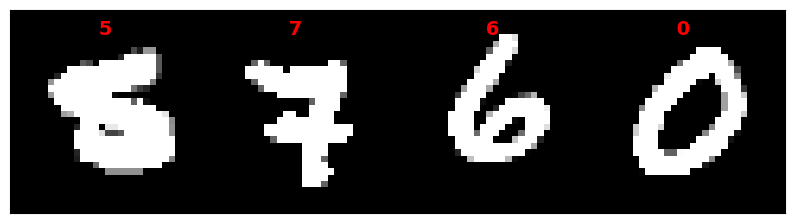

In [ ]:
# Visualizing the Data

warnings.filterwarnings("ignore")

# Load the MNIST dataset and apply normalization
mnist_data = datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=4, shuffle=True)

# Display a batch of images
for images, labels in data_loader:
    # Create a grid of images
    grid_image = utils.make_grid(images, nrow=4).permute(1, 2, 0)

    # Center the label text
    label_text = [str(label.item()).center(4) for label in labels]

    # Display the image grid and labels
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(grid_image, cmap="gray", vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(min(4, len(label_text))):
        # Calculate the position of the label text
        x = (2 * i + 1) * grid_image.shape[1] // 8
        y = grid_image.shape[0] // 32
        # Add the label text to the image
        ax.text(x, y, label_text[i], color="red", fontsize=14, fontweight="bold", ha="center", va="top")

    plt.show()
    break

In [ ]:
# Now we define the networks architecture, this is essentially the algorithm you've heard so much about.

class VerySimpleNet(nn.Module):
    def __init__(self):
        super(VerySimpleNet, self).__init__()
        # The thing to focus on is the self.fc1 - and how we define this transformation.
        # It is a linear function of size 28*28, due to the image's pixels, and also 10 after, as there is 10 classes.
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flattening the tensor
        x = self.fc1(x) # putting our data through the linear function
        output = nn.functional.log_softmax(x, dim=1) # outputting a classification via log_softmax
        return output

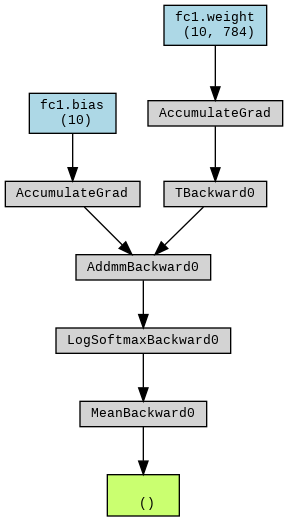

In [ ]:
# Now we will do what we call "initializing" the network and optimizer.
# We effectively tell it how to learn, to correct itself by changing the weights of nodes in the network with what we call a loss function.

very_simple_net = VerySimpleNet()
criterion = nn.NLLLoss()
optimizer = optim.SGD(very_simple_net.parameters(), lr=0.01, momentum=0.9)

# We wish to visualize:
# Create a sample input tensor
x = torch.randn(1, 1, 28, 28)
x = Variable(x)

# Pass the input tensor through the network and calculate the output
y = very_simple_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(very_simple_net.named_parameters()))
dot.format = "png"
dot.render(filename="net_graph1")

# Display the computation graph in Jupyter Notebook
Image(filename="net_graph1.png")

In [ ]:
# Now we actually train the network, so we can test it's effectiveness.

very_simple_net = to_device(very_simple_net, device) # move the model to the device (CPU or GPU)
for epoch in range(6):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = very_simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:
            print("[epoch %d, iteration %5d] loss: %.3f" %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print("Finished training")

[epoch 1, iteration   500] loss: 1.960
[epoch 2, iteration   500] loss: 1.533
[epoch 3, iteration   500] loss: 1.446
[epoch 4, iteration   500] loss: 1.462
[epoch 5, iteration   500] loss: 1.438
[epoch 6, iteration   500] loss: 1.425
Finished training


In [ ]:
# Lastly, we evaluate the network on the test data.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = very_simple_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on the test set: %d %%" % (100 * correct / total))

Accuracy on the test set: 91 %


## A Simple Model (The perfect algorithm?)

Now, a 90% classification rate is good for most purposes, but we want to do better than that. It is now time for a more complex network!

As you (should) have learned from the course so far, there are phenomena that we call overfitting and underfitting, which happen when we use a model that is too simple or too complex for the data at hand.

We then know that there should exist a perfect algorithm in the space below an overfit model and above an underfit model. Although getting to this perfect model is nearly impossible, we can stop the experiment when we consider the model appropriate. Let's do our best to find this not-so-perfect model then.

Below, you will find what we would call a simple Convolutional Neural Network (CNN). With this improved model, we hope for higher accuracy. Let's test this out.

In [ ]:
# Network architecture

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(32*13*13, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

A new function, convolution, has been introduced here. A convolution here is what we will call a matrix sliding operation. We input the image and a small matrix of numbers called a kernel (a matrix much smaller than the image).

To perform a convolution operation, we slide the kernel over the image, starting at the top left corner, and perform a series of element-wise multiplications and summations. At each location, we multiply the values in the kernel by the corresponding values in the image and sum up the results. We then store the result in the output image at the corresponding location. It is a smaller matrix than the image, as we have contracted values into a smaller space. Essentially, that is the idea of a convolution.

By doing this for every location in the input image, we can create a new output image that has been filtered or transformed in some way based on the kernel. The image below will make this much more obvious:

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/docs/images/convolution.png?raw=true)

Image source -- https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/convnet-notebook.html

We have also introduced Max Pooling, which is similar to a convolution. However, its primary goal is to reduce the dimensionality (size) of the feature maps produced by a layer of our CNN.

The basic idea behind max pooling is to divide the feature map into non-overlapping regions and then take the maximum value of each region as the output.

To perform max pooling, we first select a region of the feature map (usually a small rectangle) and then find the maximum value in that region. We then store the maximum value in a new output feature map at the corresponding location.

By repeating this process for each non-overlapping region in the feature map, we can create a new output feature map smaller than the input feature map. This process can be considered pooling the information from the input feature map since we are reducing the amount of information by selecting only the maximum values, similar to convolutions.

See below an image which describes Max Pooling:

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/docs/images/max-pooling.png?raw=true)

Image source -- https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

Now, just as before, we are now going to have to initialize the network, the criterion (i.e., the loss function), and the optimizer.

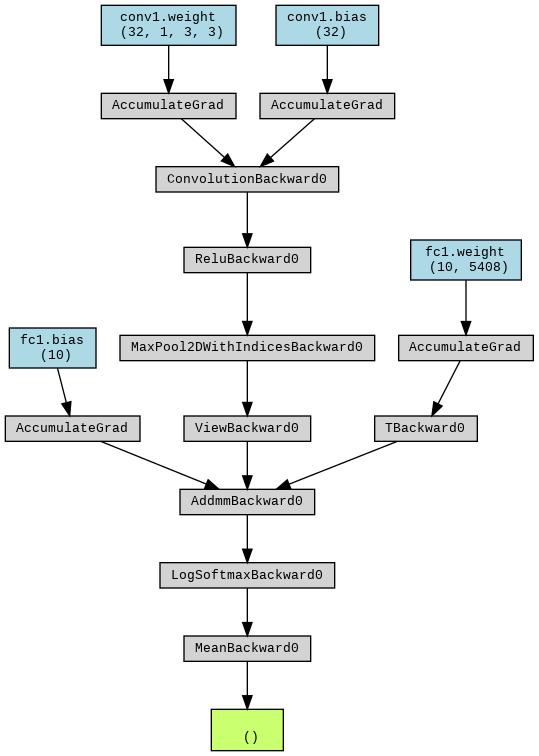

In [ ]:
# Initializing the network

simple_net = SimpleNet()
criterion = nn.NLLLoss()
optimizer = optim.SGD(simple_net.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(1, 1, 28, 28)
x = Variable(x)

# Pass the input tensor through the network and calculate the output
y = simple_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(simple_net.named_parameters()))
dot.format = "png"
dot.render(filename="net_graph2")

# Display the computation graph in Jupyter Notebook
Image(filename="net_graph2.png")

Here, the criterion is used to compute the loss or error between the predicted output of a model and the actual output. During training, the model updates its parameters based on the value of the loss computed by the criterion. PyTorch provides several built-in criterion classes, such as `nn.MSELoss` for mean squared error and `nn.CrossEntropyLoss` for multi-class classification.

In this case, we use`nn.NLLLoss`, which means the negative log-likelihood loss. Our target is a tensor of class labels. We have our loss defined as the negative of the log probabilities for each tensor input (for every tensor value, we have a unique loss). The model output takes the log of the probability of each value of the input tensor (we can use `nn.LogSoftmax` for this, for example).

On the other hand, the optimizer is how we use this loss to update the model parameters. We usually use `optim.Adam` or `optim.SGD`. Adam (adaptive moment estimation) is an adaptive SGD (stochastic gradient descent) where the learning rate is updated based on the loss function and parameters. We use SGD over Adam if our data is noisy or if we have a shallow network (like this one). In these cases, SGD converges faster. In most other cases, Adam converges much faster.

Both of these try to approach optimal parameter values by going towards the negative gradient we get from the loss function, multiplied by the learning rate, and reducing the parameter values by such.

Now we will train the model, as before:

In [ ]:
# Training

simple_net = to_device(simple_net, device) # move the model to the device (CPU or GPU)
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:
            print("[epoch %d, iteration %5d] loss: %.3f" %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print("Finished training")

[epoch 1, iteration   500] loss: 1.161
[epoch 2, iteration   500] loss: 0.366
[epoch 3, iteration   500] loss: 0.286
[epoch 4, iteration   500] loss: 0.236
[epoch 5, iteration   500] loss: 0.198
[epoch 6, iteration   500] loss: 0.162
[epoch 7, iteration   500] loss: 0.151
Finished training


The training was completed above. We will again test the accuracy of the model. We are hoping for a marginal increase in accuracy, given that we have complexified the model. See below the accuracy test:

In [ ]:
# Evaluation

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = simple_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on the test set: %d %%" % (100 * correct / total))

Accuracy on the test set: 98 %


This is quite an increase. It seems that increasing the complexity of the model is worth it.

## A Complex Model (As good as it gets?)

Out of curiosity, let us try a more complex model with more layers.

In [ ]:
# Network architecture

class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

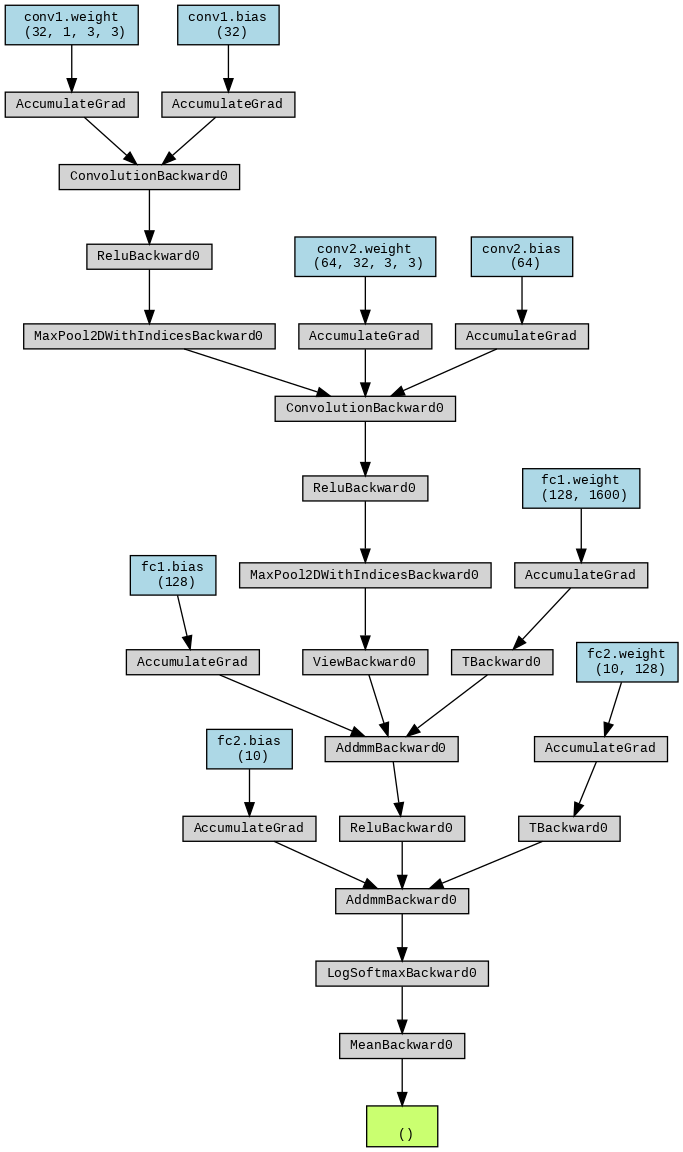

In [ ]:
# Initializing the network

complex_net = ComplexNet()
criterion = nn.CrossEntropyLoss() # note the change here
optimizer = optim.SGD(complex_net.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(1, 1, 28, 28)
x = Variable(x)

# Pass the input tensor through the network and calculate the output
y = complex_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(complex_net.named_parameters()))
dot.format = "png"
dot.render(filename="net_graph3")

# Display the computation graph in Jupyter Notebook
Image(filename="net_graph3.png")

In [ ]:
# Training

complex_net = to_device(complex_net, device) # move the model to the device (CPU or GPU)
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = complex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:
            print("[epoch %d, iteration %5d] loss: %.3f" %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print("Finished training")

[epoch 1, iteration   500] loss: 1.423
[epoch 2, iteration   500] loss: 0.263
[epoch 3, iteration   500] loss: 0.179
[epoch 4, iteration   500] loss: 0.125
[epoch 5, iteration   500] loss: 0.087
[epoch 6, iteration   500] loss: 0.067
[epoch 7, iteration   500] loss: 0.058
Finished training


In [ ]:
# Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = complex_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on the test set: %d %%" % (100 * correct / total))

Accuracy on the test set: 99 %


This complex model only gives us a marginal increase in accuracy. Is it worth the effort?

## Explainability

Apart from performance, another feature to consider when developing an AI system is its **explainability**, i.e., the ability to show why the model makes decisions in the way it does.

Explainability is important for several reasons. Having explanations for a model's decisions not only helps build trust in them but also increases productivity when debugging the model or tackling areas of improvement.

New techniques have been developed to improve explainability in complex ML models in recent years. We will look at [GradCAM (Gradient-weighted Class Activation Mapping)](https://arxiv.org/abs/1610.02391), a model that shows the regions in the image that helped the model in making decisions for CNNs of different architectures. It is a generalization of [CAM (Class Activation Mapping)](https://arxiv.org/abs/1512.04150). The function `display_grad_cam` computes and displays the GradCAMs of a batch of images for a given method:

In [ ]:
def scale_to_01(arr):
    """
    Scales an array so all its values lie in the interval [0, 1].

    Parameters
    ----------
    arr : numpy.array
        The original array.

    Returns
    -------
    numpy.array
        The sclaed array.
    """
    min_val = arr.min()
    max_val = arr.max()
    scaled_array = (arr - min_val) / (max_val - min_val)
    return scaled_array


def display_grad_cam(model, target_layers, images):
    """
    Computes and displays the GradCAM for a convolutional neural network for a
    batch of images.

    Parameters
    ----------
    model : nn.Module
        Model on which we want to compute the GradCAM.
    target_layers : List[nn.Module]
        List of convolutional layers where the GradCAM is computed. If a list
        with several layers is provided, the CAM will be averaged accross them.
    images: torch.Tensor
        Batch of images for which the GradCAM shall be computed.
    """
    # Appply GradCAM to the images
    grad_cam = GradCAM(model=model, target_layers=target_layers)
    cams = grad_cam(input_tensor=images,
                    targets=None,
                    aug_smooth=True,
                    eigen_smooth=True)

    # Convert images to numpy arrays and scale them to [0,1]
    # This step is necessary for the show_cam_on_image funciton to work
    images = scale_to_01(np.array(images.permute(0, 2, 3, 1).cpu()))

    # Merge each image with its CAM
    cam_images = []
    for image, cam in zip(images, cams):
        cam_images.append(show_cam_on_image(image, cam, use_rgb=True))
    cam_images = torch.tensor(cam_images)

    # Display grid with cams of all images in the batch
    nrow = 6
    img_size_factor = 1.5
    grid_image = utils.make_grid(cam_images.permute(0, 3, 1, 2), nrow=nrow).permute(1, 2, 0)

    plt.figure(figsize=(nrow*img_size_factor, ((images.shape[0]/nrow)+1)*img_size_factor))
    plt.title("Model: " + model.__class__.__name__)
    plt.axis("off")
    plt.imshow(grid_image, vmin=0, vmax=1)
    plt.show()

Let's display some GradCAMS for all the convolutional networks that we have trained. It is common to select the **last convolutional layer** as target layer, but feel free to try it out with other layers (or a combination of them).

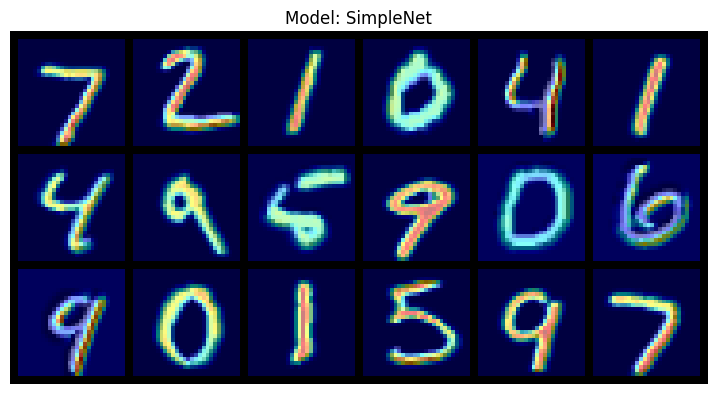

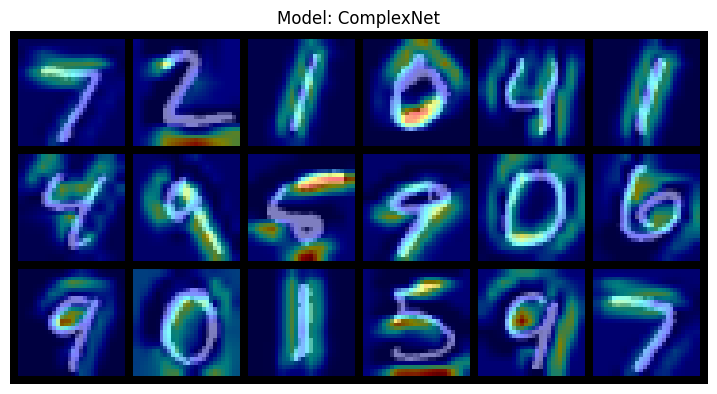

In [ ]:
# Get a batch of (64) images
images, _ = next(iter(testloader))

# Select only 18 images
images = images[0:18]

# Display GradCAM on the last convolutional layer of each model
model_layer = [(simple_net, [simple_net.conv1]), (complex_net, [complex_net.conv2])]
for model, target_layers in model_layer:
    model.eval()
    display_grad_cam(model, target_layers, images)

The plots show the CAMs on top of the original images. The GradCAMs use a warmer color on the pixels that are more relevant to the classification decision and a colder color on the ones that are less relevant.

What differences can you spot between the explanations for the different models?

Which one of these models will you use? Think about their accuracy and the result from the GradCAM. Did you notice anything weird in the GradCAM for some models? Briefly explain why you picked the model you did so you can justify to your colleagues why they will continue working further with it!